The goal of this project is to use the pretrained RoBERTa transformer as a feature extractor with a costum classification head to determine if text messages are offensive or not.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

import wandb

import sys
from pathlib import Path

# Add src/ to path (once, so imports work)
sys.path.append(str(Path().resolve().parent / "src"))

%load_ext autoreload
%autoreload 2
from helper_functions import AttentionPooling, HateSpeechDataset
from helper_functions import train_model, test_model, get_class_distribution, oversample_dataset, undersample_dataset
from models import CustomClassifier, LargeCustomClassifier

In [2]:
from paths import DATA_CLEANED, DATA_PROCESSED
print("Cleaned data path:", DATA_CLEANED)
print("Processed data path:", DATA_PROCESSED)

Cleaned data path: /Project/data/cleaned
Processed data path: /Project/data/processed


In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Using RoBERTa as a feature extractor with a costum classification head

Found this pretrained model online: cardiffnlp/twitter-roberta-base-sentiment-latest (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

It is already pretrained on twitter messages. 

Define which pretrained model is used and initilise tokenizer

In [4]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

## Load HASOC dataset for training, validation and testing

Define experiment scope:

In [5]:
# here we are just using the labels of the first task of the HASOC dataset, which is a binary classification
label = "task_1"

In [6]:
# Load training and test data
clean_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv", sep='\t')
# test_df = pd.read_csv(DATA_PROCESSED / "hasoc_2019_en_test.tsv", sep='\t')
test_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_test_cleaned.tsv", sep='\t')

# Split clean dataset in training and validation set
train_df, val_df = train_test_split(clean_df, test_size=0.3, random_state=42, stratify=clean_df[label])

# Automatically map string labels to integers
label_list = sorted(train_df[label].unique())
label_map = {label: idx for idx, label in enumerate(label_list)}

train_df[label] = train_df[label].map(label_map)
val_df[label] = val_df[label].map(label_map)
test_df[label] = test_df[label].map(label_map)

In [7]:
# Decide which technique to use to cope with data imbalance
handling_imbalance = "class_weighting"
# when choosing 'class_weighting' dataset is not touched but classes gets weighted depending on label/class distribution

if handling_imbalance == 'oversampling':
    # Oversample dataset
    train_df = oversample_dataset(train_df, label)
    # val_df = oversample_dataset(val_df, label) # over and undersampling only useful for training dataset
    # test_df = oversample_dataset(test_df, label)
elif handling_imbalance == 'undersampling':
    # Undersample dataset
    train_df = undersample_dataset(train_df, label)
    # val_df = undersample_dataset(val_df, label)
    # test_df = undersample_dataset(test_df, label)

In [8]:
# Create PyTorch Datasets and DataLoaders
train_dataset = HateSpeechDataset(train_df, tokenizer, label=label)
val_dataset = HateSpeechDataset(val_df, tokenizer, label=label)
test_dataset = HateSpeechDataset(test_df, tokenizer, label=label)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=32)

print(get_class_distribution(train_df, label))

{1: 2513, 0: 1583}


In [9]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df[label]),
    y=train_df[label]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

## Training and evaluation of model

In [10]:
# Decide what pooling to use (cls, mean or attention_pooling)
pooling = "mean"

# Initialize model
model = LargeCustomClassifier(model_name, class_weights_tensor, device, pooling=pooling).to(device)


# Set learning rate
learning_rate = 2e-4

# Optimizer only for the classification head
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate)
epochs = 100

2025-05-14 20:41:44.859010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 20:41:44.874597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747248104.896962   64354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747248104.902963   64354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747248104.917859   64354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [11]:
wandb.init(project="roberta-classifier", config={
    "model": model_name,
    "frozen_base": True,
    "pooling": pooling,
    "classifier_head": model.__class__.__name__,
    "epochs": epochs,
    "lr": learning_rate,
    "handling_imbalance": handling_imbalance
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: natalia-timokhova-v (natalia-timokhova-v-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
train_model(model, train_loader, val_loader, optimizer, device, epochs)


Epoch 1
Training Loss: 0.6780
Train Accuracy: 0.5862
Train F1 (macro): 0.5632

Val Loss: 0.6640
Val Accuracy: 0.5438
Val F1 (macro): 0.5404

New best model saved (F1: 0.5404, Acc: 0.5438)

Epoch 2
Training Loss: 0.6452
Train Accuracy: 0.6262
Train F1 (macro): 0.6158

Val Loss: 0.6384
Val Accuracy: 0.6304
Val F1 (macro): 0.6256

New best model saved (F1: 0.6256, Acc: 0.6304)

Epoch 3
Training Loss: 0.6287
Train Accuracy: 0.6472
Train F1 (macro): 0.6357

Val Loss: 0.6387
Val Accuracy: 0.6036
Val F1 (macro): 0.6036


Epoch 4
Training Loss: 0.6179
Train Accuracy: 0.6638
Train F1 (macro): 0.6532

Val Loss: 0.6269
Val Accuracy: 0.6674
Val F1 (macro): 0.6577

New best model saved (F1: 0.6577, Acc: 0.6674)

Epoch 5
Training Loss: 0.6136
Train Accuracy: 0.6660
Train F1 (macro): 0.6546

Val Loss: 0.6316
Val Accuracy: 0.6202
Val F1 (macro): 0.6190


Epoch 6
Training Loss: 0.6120
Train Accuracy: 0.6611
Train F1 (macro): 0.6509

Val Loss: 0.6308
Val Accuracy: 0.6760
Val F1 (macro): 0.6431


Epoch 

## Testing of model

Test Loss: 0.5469
Test Accuracy: 0.7728
Test F1 (macro): 0.7304



epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
train_f1_macro,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
train_f1_weighted,▁▂▂▂▂▂▃▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████████
train_loss,█████▇▇▇▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁


{'f1': 0.7304151495680731, 'accuracy': 0.7727666955767563}

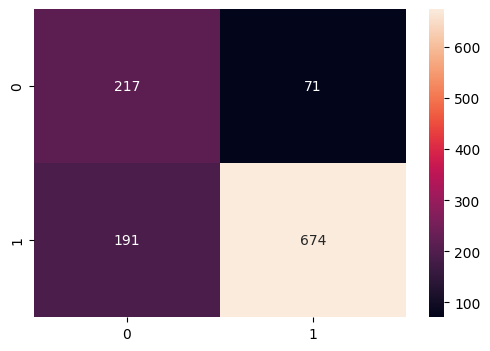

In [13]:
# Load best model
model.load_state_dict(torch.load("best_model.pt", weights_only=True))
# Test model on test set
test_model(model, test_loader, device, phase = "test")